In [17]:
import re
from enum import Enum
from typing import List, Tuple, Dict, Set, Optional, Union, Any, Callable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
def replace_multiple_spaces_by_one(s):
    return re.sub(r" +", " ", s)

In [19]:
class Unit(Enum):
    ns = 1000000000
    us = 1000000
    ms = 1000
    s = 1
    nop = 0

    def __str__(self):
        return self.name

def get_unit(s):
    unit = s.replace("/op", "")
    if unit == "ns":
        return Unit.ns
    elif unit == "us":
        return Unit.us
    elif unit == "ms":
        return Unit.ms
    elif unit == "s":
        return Unit.s
    else:
        raise Exception("Unknown unit")
    
def convert(n:float, current_unit:Unit, new_unit:Unit) -> float:
    return n * new_unit.value / current_unit.value

def verify_unit_or_convert(data: Tuple[Unit, List[Tuple[int, float, float]]], other_data: Tuple[Unit, List[Tuple[int, float, float]]] = ()) -> Tuple[Unit, List[Tuple[int, float, float]]]:
    unit = data[0] if other_data == () else other_data[0]
    if other_data == ():
        # Convert to the best unit for viewing the data
        min_value = min([x[1] for x in data[1]])
        if min_value / float(1000000000) > 1:
            unit = Unit.s
        elif min_value / float(1000000) > 1:  
            unit = Unit.ms
        elif min_value / float(1000) > 1:
            unit = Unit.us
        else:
            unit = Unit.ns
    u = data[0]
    res = [(x, convert(avg, u, unit), convert(err, u, unit)) for x, avg, err in data[1]]
    res.sort()
    return (unit, res)

In [20]:
def extract_benchmark(data: Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]])-> Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]: 
  result = {}
  for benchmark in data:
    map_type = benchmark.split("_")[-1]
    benchmark_name = benchmark.replace(f"_{map_type}", "")
    if not benchmark_name in result:
      result[benchmark_name] = {}
    result[benchmark_name][map_type] = data[benchmark]
  return result

def extract_benchmark_class(data: Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]) -> Dict[str, Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]]:
  result = {}
  for benchmark_class_name in data:
    
    benchmark_class = benchmark_class_name.replace("benchmark.", "").split(".")[0]
    benchmark_name = benchmark_class_name.replace("benchmark.", "").replace(f"{benchmark_class}.", "")
    if not benchmark_class in result:
      result[benchmark_class] = {}
    result[benchmark_class][benchmark_name] = data[benchmark_class_name]
  return result



def extract_from_JMH_logs(s: List[str]) -> Dict[str, Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]]:
  """
  Extracts the data from the JMH logs
  In following format: {benchmark_name: {parameter_value: (unit, [data])}}}
  """
  i = 0
  result = {}
  while i < len(s):
    # First consume until we find the name of the next benchmark
    while i < len(s) and not "[info] # Benchmark:" in s[i]:
      i += 1
    if i >= len(s):
      break
    # Get the name
    benchmark_name = s[i].split("# Benchmark:")[1].strip()

    # Consume until we find the parameter value
    while not "[info] # Parameters:" in s[i]:
      i += 1

    # Get the parameter value
    parameter_value = s[i].split("# Parameters:")[1].strip().replace("(", "").replace(")", "")
    parameter_name = parameter_value.split("=")[0].strip()
    parameter_value = int(parameter_value.split("=")[1].strip())
    # Consume until we find the first iteration value
    while not "[info] Iteration   1:" in s[i]:
      i += 1
    
    # Extract the unit and data
    unit = get_unit(s[i].replace("[info] Iteration   1:", "").strip().split(" ")[-1].strip())
    data = []
    data.append(float(s[i].replace("[info] Iteration   1:", "").strip().split(" ")[0].strip()))
    i += 1
    while not "[info] Result" in s[i]:
      data.append(float(s[i].split(":")[1].strip().split(" ")[0].strip()))
      i += 1

    # Add the data to the dictionary
    if not benchmark_name in result:
      result[benchmark_name] = {}
    if parameter_value != 0:
      result[benchmark_name][(parameter_name, parameter_value)] = (unit, data)
  
  return extract_benchmark_class(extract_benchmark(result))


In [21]:
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import numpy as np, scipy.stats as st

def extract_data(raw_data: Dict[Tuple[str, int], Tuple[Unit, List[float]]], merge_datapoints: int = 1, confidence=0.95) -> Tuple[str, Unit, List[Tuple[int, float, float]]]:
    """
    Compute statistics of the data from the raw data, returning the name of the parameter, the unit, and the data
    """
    raw_data_list = list(raw_data.items())
    unit = raw_data_list[0][1][0]
    result = []
    i = 0
    while i < len(raw_data_list):
        j = 0
        points = []
        param_value = 0
        while j < merge_datapoints and i + j < len(raw_data_list):
            assert(raw_data_list[i][1][0] == unit)
            param_value += raw_data_list[i + j][0][1]
            points.append(raw_data_list[i + j][1][1])
            j += 1
        points = [p for sublist in points for p in sublist]
        param_value = param_value / merge_datapoints
        mean = np.mean(points)
        std_dev = np.std(points, ddof=1)  # ddof=1 provides the sample standard deviation
        sample_size = len(points)
        df = sample_size - 1
        std_err = std_dev / np.sqrt(sample_size)
        ci = st.t.interval(confidence, df, loc=mean, scale=std_err)
        err = (ci[1] - ci[0]) / 2
        result.append((param_value, mean, err))

        i += j
    return (raw_data_list[0][0][0], unit, result)

def extract_data_normalised_per_op(raw_data: Dict[Tuple[str, int], Tuple[Unit, List[float]]], merge_datapoints: int = 1, confidence=0.95) -> Tuple[str, Unit, List[Tuple[int, float, float]]]:
    """
    Compute statistics of the data from the raw data, returning the name of the parameter, the unit, and the data
    Normalises values by the number of operations, so divided by the value of the parameter
    """
    raw_data_list = list(raw_data.items())
    unit = raw_data_list[0][1][0]
    result = []
    i = 0
    while i < len(raw_data_list):
        j = 0
        points = []
        param_value = 0
        while j < merge_datapoints and i + j < len(raw_data_list):
            assert(raw_data_list[i][1][0] == unit)
            param_value += raw_data_list[i + j][0][1]
            norm_data = [x/raw_data_list[i + j][0][1] for x in raw_data_list[i + j][1][1] if raw_data_list[i + j][0][1] != 0]
            points.append(norm_data)
            j += 1

        points = [p for sublist in points for p in sublist]
        param_value = param_value / merge_datapoints
        mean = np.mean(points)
        std_dev = np.std(points, ddof=1)  # ddof=1 provides the sample standard deviation
        sample_size = len(points)
        df = sample_size - 1
        std_err = std_dev / np.sqrt(sample_size)
        ci = st.t.interval(confidence, df, loc=mean, scale=std_err)
        err = (ci[1] - ci[0]) / 2
        result.append((param_value, mean, err))

        i += j
    return (raw_data_list[0][0][0], unit, result)

def normalise_data_wrt_value(data: Tuple[Unit, List[Tuple[int, float, float]]], value: float)-> Tuple[Unit, List[Tuple[int, float, float]]]:
    return (Unit.nop, [(x, avg/value, err/value) for x, avg, err in data[1]])

def reduce_(data: Tuple[Unit, List[Tuple[int, float, float]]], value: float)-> Tuple[Unit, List[Tuple[int, float, float]]]:
    return (Unit.nop, [(x, avg/value, err/value) for x, avg, err in data[1]])

In [22]:
def plot_data_with_error(plot_name: str,
                         data: Dict[str, Tuple[str, List[Tuple[int, float, float]]]],
                          x_line_at: int = 0, 
                          show_avg: bool = False, 
                          output_folder = "",
                          differentiator: str = "colour"):
    final_unit = None
    data_without_units: Dict[str, List[Tuple[int, float, float]]]= {}
    for name, (unit, dat) in data.items():
        data_without_units[name] = dat
        if final_unit is not None:
            assert final_unit == unit
        else:
            final_unit = unit
    
    assert len(data.keys()) <= 8


    fig, ax = plt.subplots()

    # Choose colorblind-friendly colors
    colours = ['tab:blue', 'tab:green', 'xkcd:barbie pink', 'tab:cyan', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    colorBlack = 'black'

    line_styles = ['-', '--', '-.', ':']
    markers=['.', 'x', '_', '^', '*', '<', '>', 'p', 'h', 'H', 'D', 'd', 'P', 'X']

    # the error bar is shown in another color, and it the 99% CI
    # The y-axis always starts at 0
    for i, (name, dat) in enumerate(data_without_units.items()):
        if differentiator == "line":
            ax.errorbar([x for x, _, _ in dat], [y for _, y, _ in dat], yerr=[y for _, _, y in dat], 
                        label=name, 
                        ecolor=colorBlack, 
                        elinewidth=0.8, 
                        capsize=2, 
                        capthick=0.8, 
                        color=colours[i % len(colours)], 
                        # linestyle=line_styles[i % len(line_styles)], 
                        linestyle="None",
                        marker=markers[i % len(markers)], 
                        markersize=6)
        else:
            ax.errorbar([x for x, _, _ in dat], [y for _, y, _ in dat], yerr=[y for _, _, y in dat], 
                        label=name, 
                        ecolor=colorBlack, 
                        elinewidth=0.8, 
                        capsize=2, 
                        capthick=0.8, 
                        color=colours[i % len(colours)])

    avgs = {}
    for name, dat in data_without_units.items():
        avgs[name] = sum([y for _, y, _ in dat]) / len(dat) if len(dat) > 0 else 0

    max_y_value = max([y for l in data_without_units.values() for _, y, _ in l])

    max_y_value = max_y_value + 0.15 * max_y_value
    ax.set_xlabel("N")
    ax.set_ylabel(f"Time ({final_unit})")

    # Add a vertical line at x = x_line_at if not 0
    if x_line_at != 0:
        ax.axvline(x=x_line_at, color=colorBlack, linestyle='--')

    if show_avg:
        for i, (name, avg) in enumerate(avgs.items()):
            ax.axhline(y=avg, color=colours[i], linestyle="--")

    ax.legend()
    ax.set_title(plot_name)
    
    if output_folder != "":
        # fig.savefig(f"{output_folder}/{plot_name}.png", format='png', dpi=1200)
        file_name = plot_name.replace(" - ", "_").replace(" ", "_").replace("^", "to").replace("&", "and").replace(",", "").replace("(", "").replace(")", "").replace(":", "").replace("/", "_")
        fig.savefig(f"{output_folder}/{file_name}.eps", format='eps')

    plt.show()

def create_one_benchmark(benchmark_class: str,
                    benchmark_name: str,
                    maps_to_show: List[str],
                    baseline: str,
                    data: Dict[str, Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]],
                    merge_points = 1,
                    merge_points_when_normalising_per_op = 1,
                    confidence = 0.95,
                    x_line_at: int = 0,
                    show_avg_for: str = "never",
                    create_norm_per_op: bool = False,
                    pretty_benchmark_names: Dict[str, str] = {}, 
                    output_folder = "",
                    differentiator: str = "colour"):
    benchm_name = f"{benchmark_class}.{benchmark_name}"
    bench_name_pretty = f"{benchmark_name}"
    if benchm_name in pretty_benchmark_names:
        bench_name_pretty = pretty_benchmark_names[benchm_name]

    baseline_data_with_param: Tuple[str, Unit, List[Tuple[int, float, float]]] = extract_data(data[benchmark_class][benchmark_name][baseline], merge_datapoints=merge_points, confidence=confidence)
    parameter_name = baseline_data_with_param[0]
    baseline_data = verify_unit_or_convert((baseline_data_with_param[1], baseline_data_with_param[2]))
    current_data = {}
    current_data[baseline] = baseline_data
    for m in maps_to_show:
        m_data = extract_data(data[benchmark_class][benchmark_name][m], merge_datapoints=merge_points, confidence=confidence)
        m_data = (m_data[1], m_data[2])
        current_data[m] = verify_unit_or_convert(m_data, baseline_data)
    
    plot_data_with_error(plot_name=bench_name_pretty, data=current_data, x_line_at=x_line_at, show_avg=show_avg_for == "always", output_folder = output_folder, differentiator=differentiator)

    # Create the same plot but normalised with respect to the first value of the baseline
    val_normalised_against = baseline_data[1][0][1]

    normalised_data = {}
    for m in maps_to_show:
        normalised_data[m] = normalise_data_wrt_value(current_data[m], val_normalised_against)

    plot_data_with_error(plot_name=bench_name_pretty + " (norm.)", data=normalised_data, x_line_at=x_line_at, show_avg=show_avg_for == "always", output_folder = output_folder, differentiator=differentiator)

    if create_norm_per_op:
        baseline_data_per_op_with_param = extract_data_normalised_per_op(data[benchmark_class][benchmark_name][baseline], merge_datapoints=merge_points_when_normalising_per_op, confidence=confidence)
        parameter_name = baseline_data_per_op_with_param[0]
        baseline_data_per_op = verify_unit_or_convert((baseline_data_per_op_with_param[1], baseline_data_per_op_with_param[2]))
        data_normalised_per_op = {}
        data_normalised_per_op[baseline] = baseline_data_per_op
        for m in maps_to_show:
            m_data = extract_data_normalised_per_op(data[benchmark_class][benchmark_name][m], merge_datapoints=merge_points_when_normalising_per_op, confidence=confidence)
            m_data = (m_data[1], m_data[2])
            data_normalised_per_op[m] = verify_unit_or_convert(m_data, baseline_data_per_op)
        
        plot_data_with_error(plot_name=bench_name_pretty + " (per op)", data=data_normalised_per_op, x_line_at=x_line_at, show_avg=show_avg_for == "normalised", output_folder = output_folder, differentiator=differentiator)
        
        # Create the same plot but normalised with respect to the avg value of the baseline
        val_normalised_against = float(np.mean([y for _, y, _ in data_normalised_per_op[baseline][1]]))

        normalised_data_per_op_wrt_baseline = {}
        for m in data_normalised_per_op:

            normalised_data_per_op_wrt_baseline[m] = normalise_data_wrt_value(data_normalised_per_op[m], val_normalised_against)
        
        plot_data_with_error(bench_name_pretty + " (per op, norm.)", normalised_data_per_op_wrt_baseline, x_line_at, show_avg_for == "normalised", output_folder = output_folder, differentiator=differentiator)

    
def create_plots(maps_to_show: List[str], 
                 baseline: str, 
                 data: Dict[str, Dict[str, Dict[str, Dict[Tuple[str, int], Tuple[Unit, List[float]]]]]],
                 merge_points=1,
                 merge_points_when_normalising_per_op=2,
                 show_avg_for: str = "never", 
                 confidence_level: float = 0.95,
                 pretty_benchmark_names: Dict[str, str] = {}, 
                 output_folder = "",
                 differentiator: str = "colour"):
    for bench_class in data:
        for bench_name in data[bench_class]:
            x_line_at = 0
            if "MutableLongMapBenchmarkBig" in bench_class:
                x_line_at = 2**22
            elif "MutableLongMapBenchmark" in bench_class:
                x_line_at = 2**15
            
            create_one_benchmark(bench_class, 
                                bench_name, 
                                maps_to_show, 
                                baseline, 
                                data, 
                                merge_points=merge_points,
                                merge_points_when_normalising_per_op=merge_points_when_normalising_per_op,
                                confidence=confidence_level,
                                x_line_at=x_line_at,
                                show_avg_for=show_avg_for, 
                                create_norm_per_op=True,
                                pretty_benchmark_names=pretty_benchmark_names, 
                                output_folder=output_folder,
                                differentiator=differentiator)

# Clean version

This version does not support data from ListMap Benchmark, for this use the benchmark_analysis_dev.ipynb notebook.

## Below here data from benchmark 24.11 on laraquad3

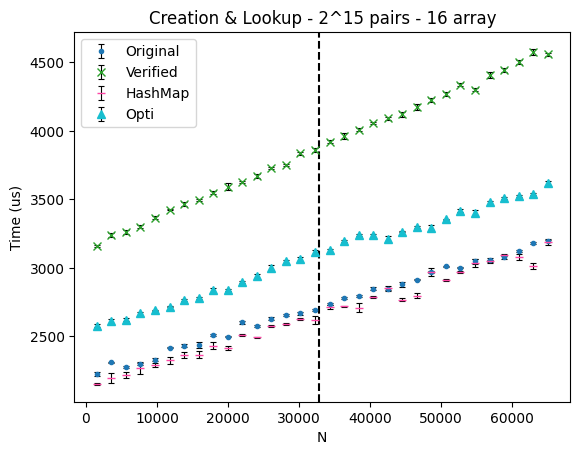

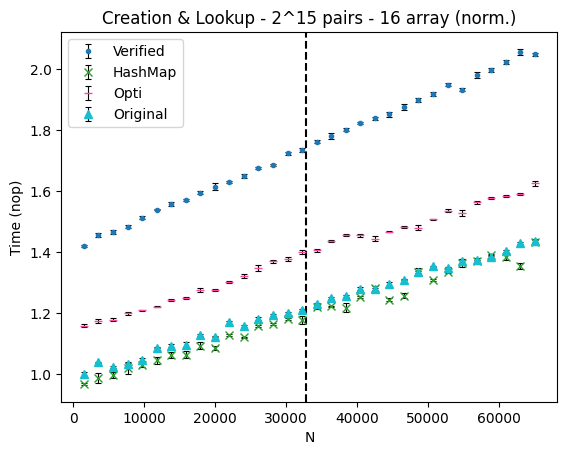

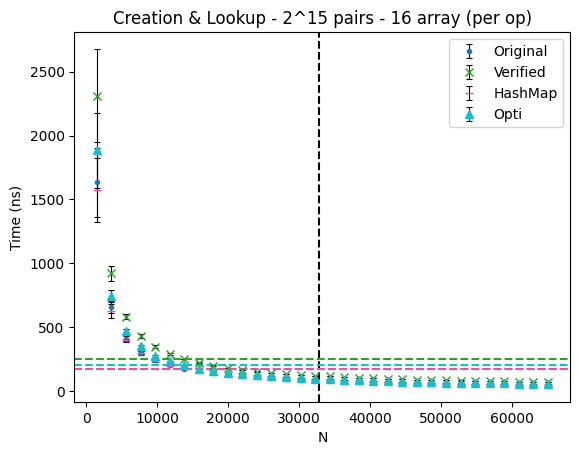

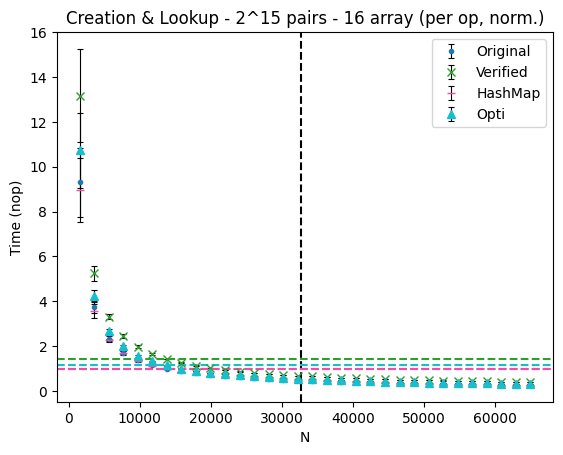

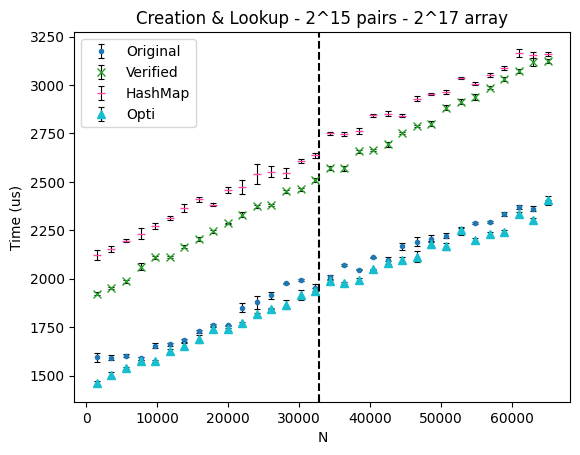

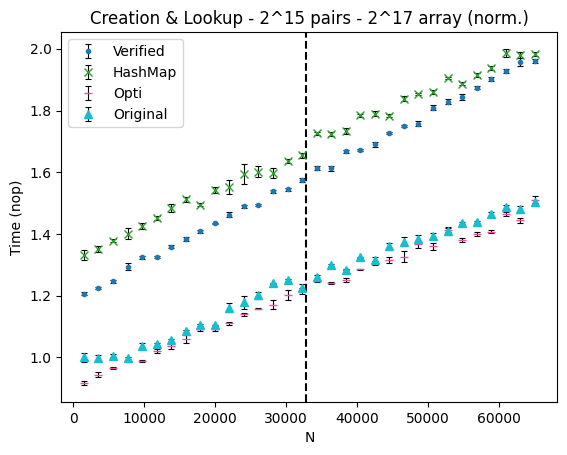

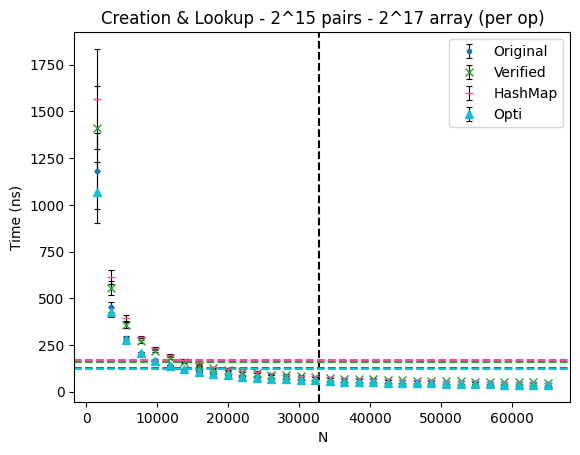

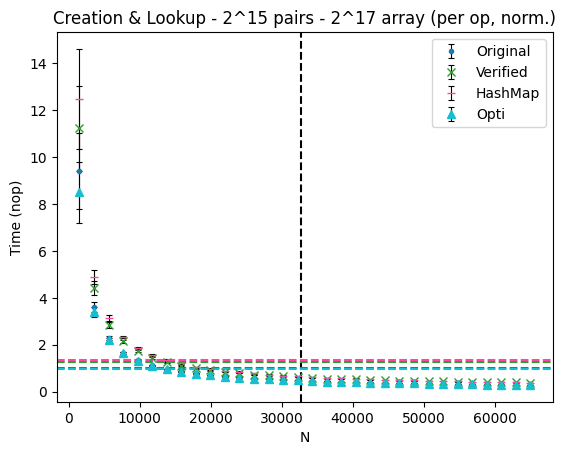

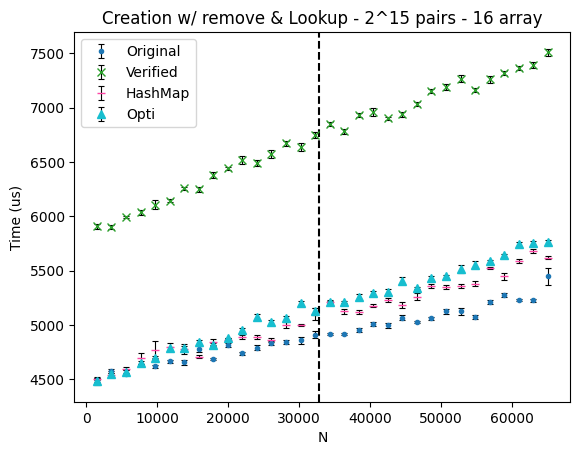

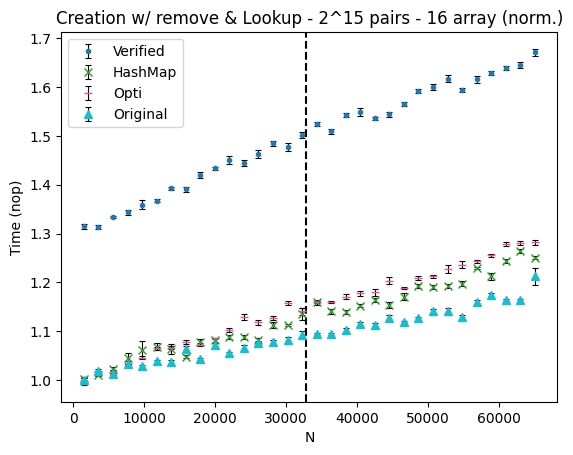

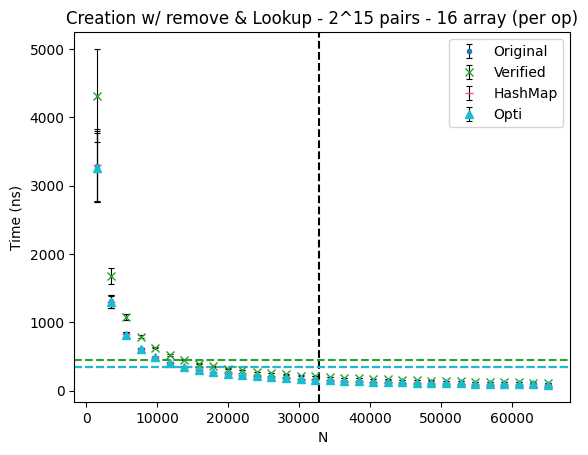

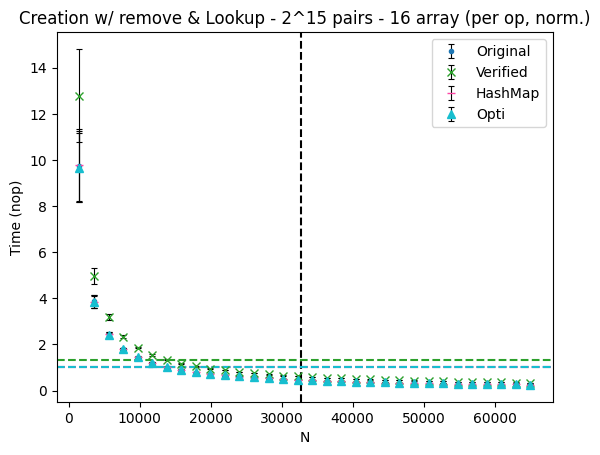

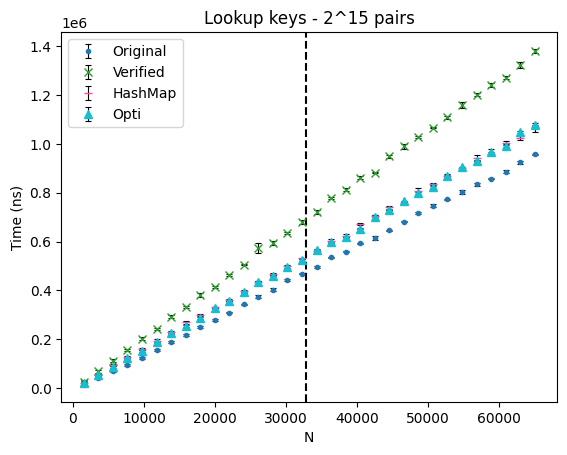

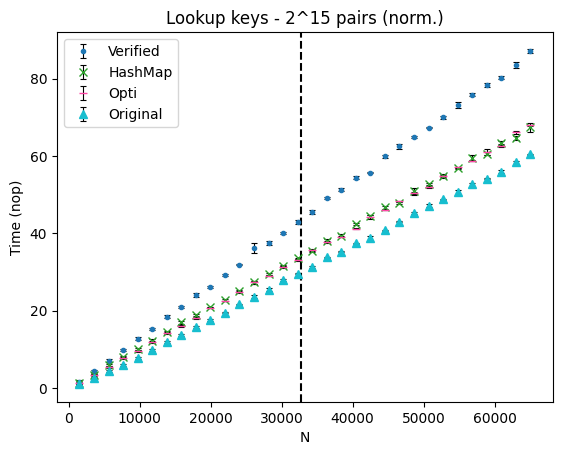

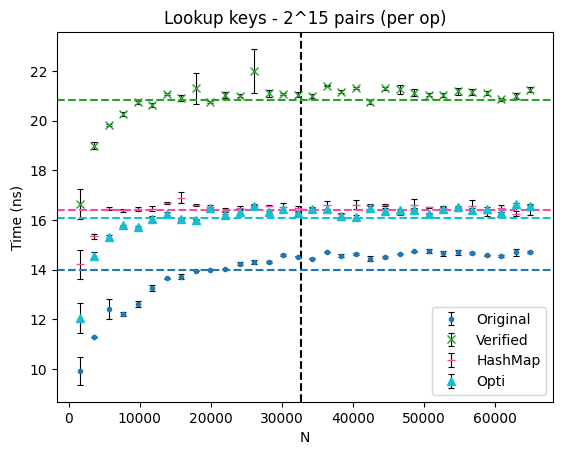

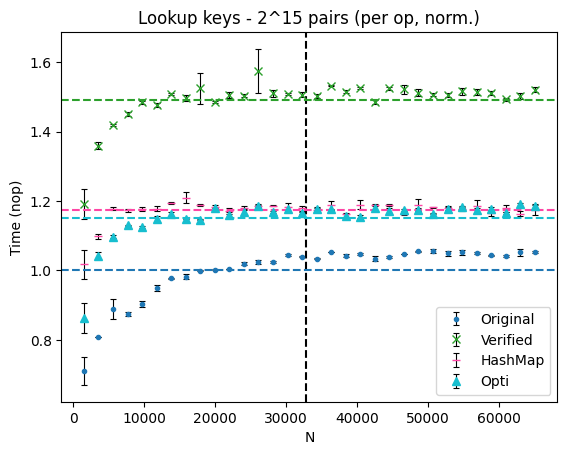

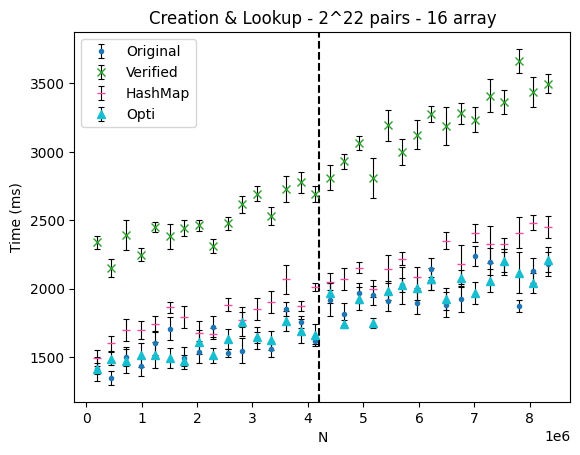

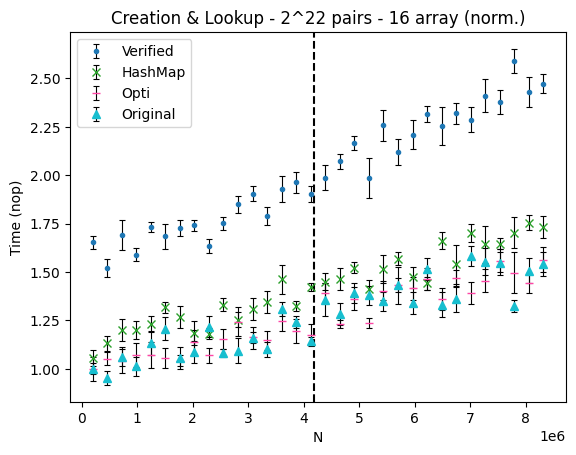

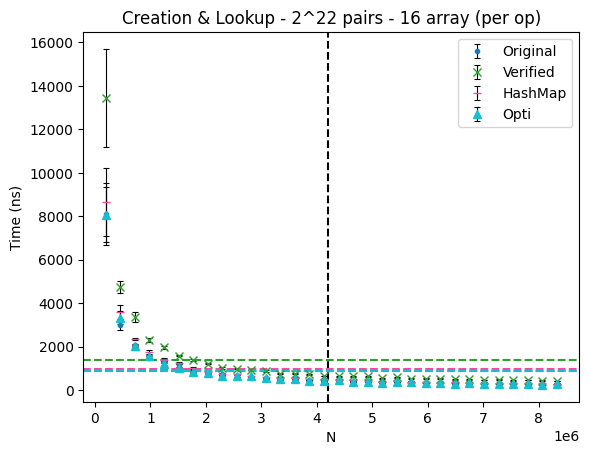

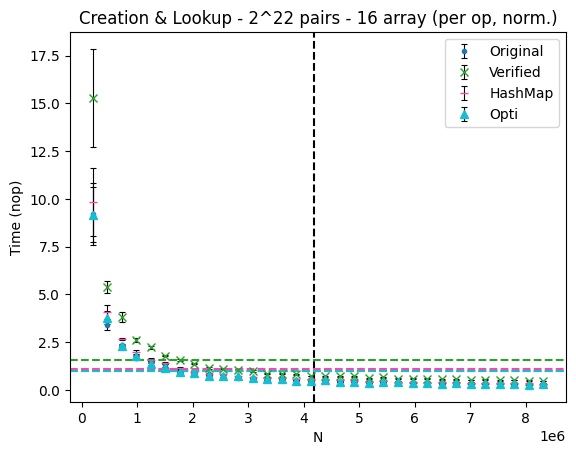

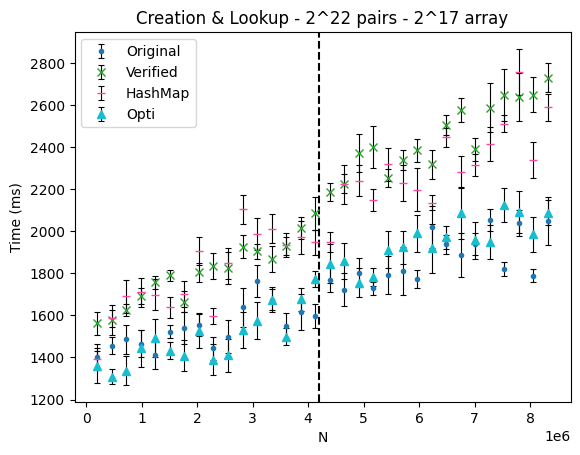

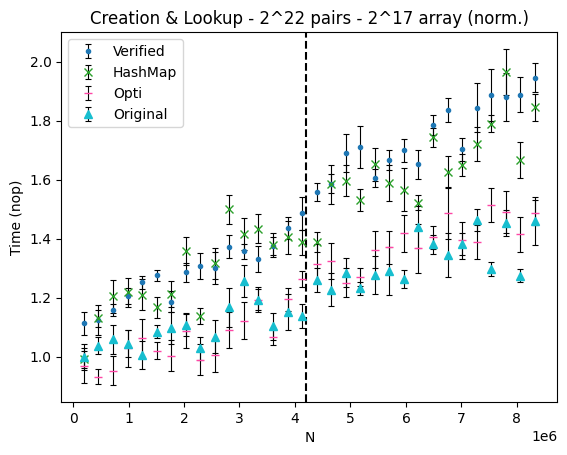

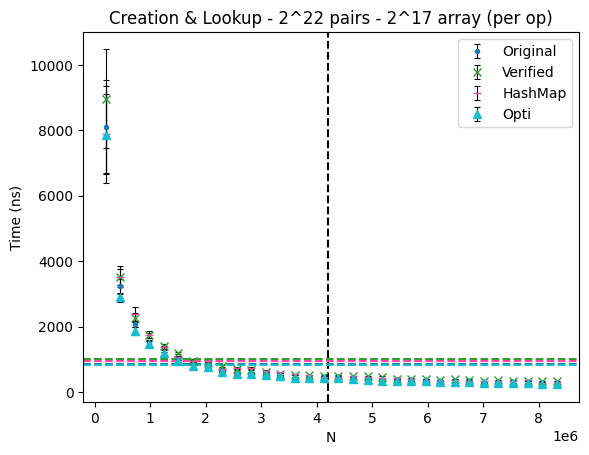

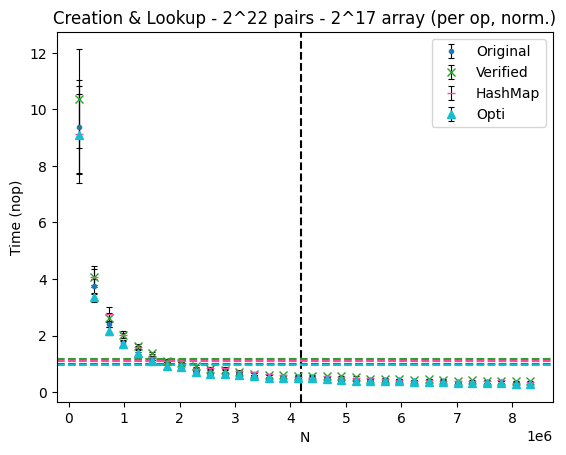

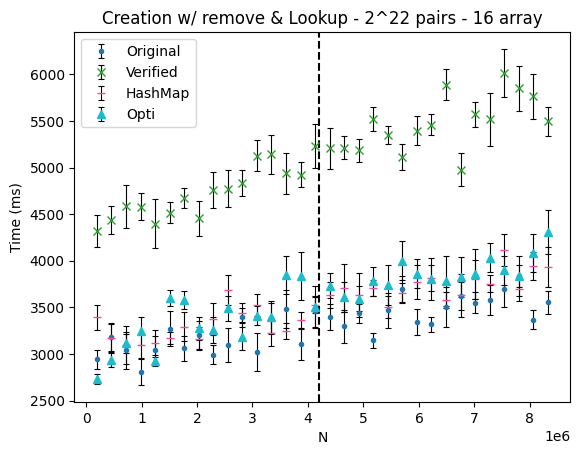

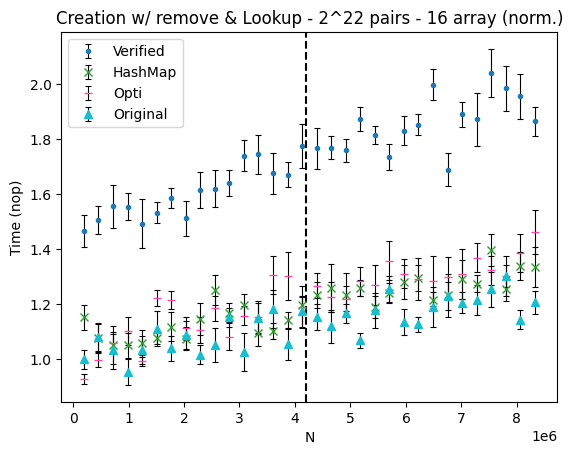

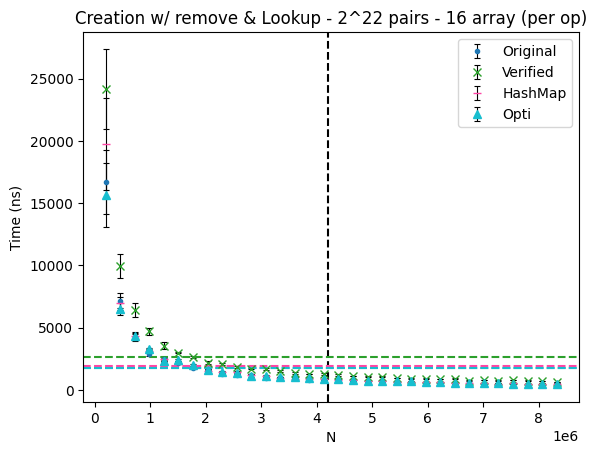

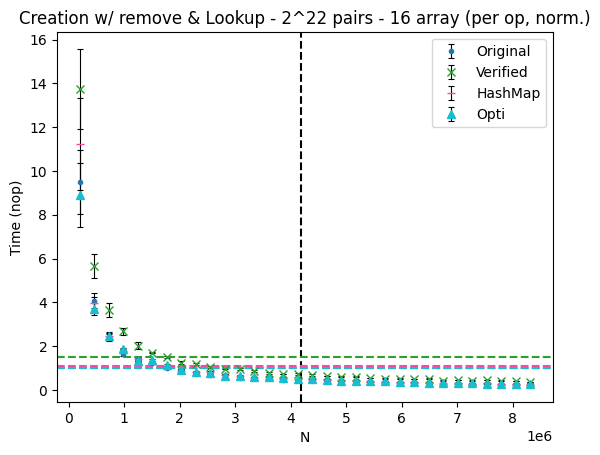

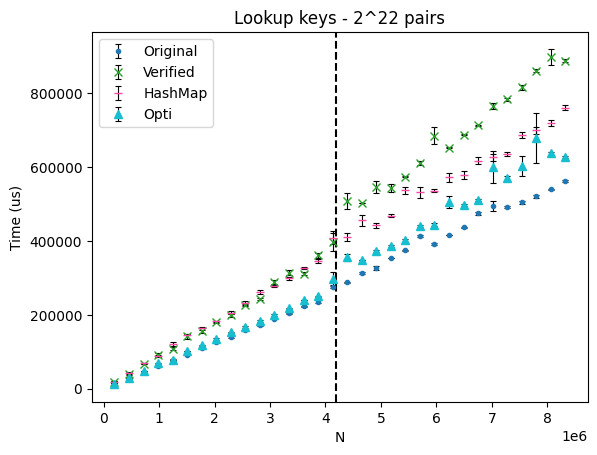

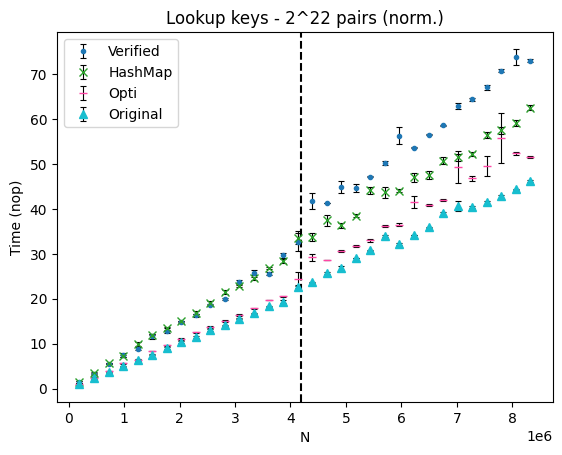

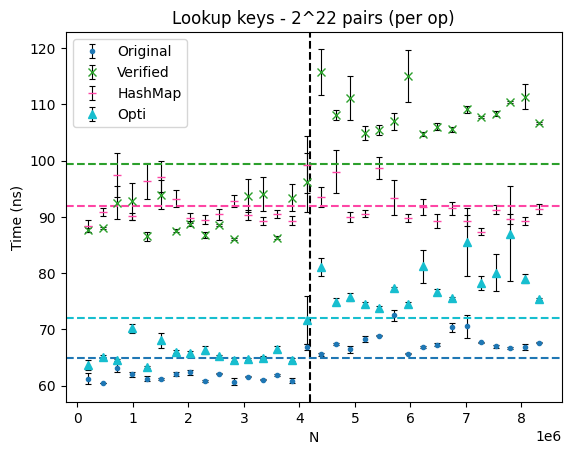

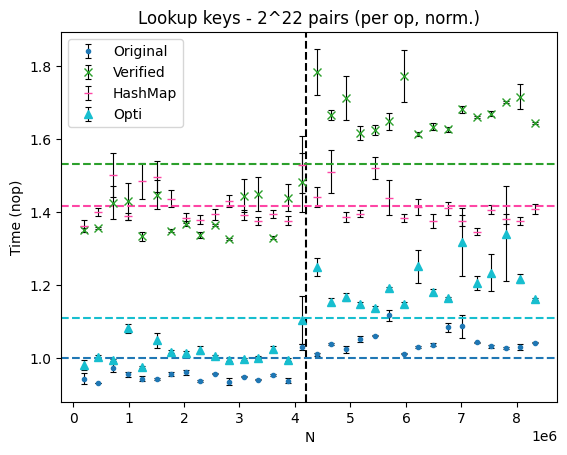

In [23]:
with open("../mutablemap/benchmark_results/benchmark_wi10_i10_NOT_ListMap__01__24_11_laraquad3.txt") as f:
  data = f.readlines()
  d = extract_from_JMH_logs(data)

benchmark_pretty_names = {}
benchmark_pretty_names["MutableLongMapBenchmarkBig.lookupN"] = "Lookup keys - 2^22 pairs"
benchmark_pretty_names["MutableLongMapBenchmark.lookupN"] = "Lookup keys - 2^15 pairs"

benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation w/ remove & Lookup - 2^22 pairs - 16 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_16Buffer"] = "Creation w/ remove & Lookup - 2^15 pairs - 16 array"
benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation w/ remove & Lookup - 2^22 pairs - 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateRemoveUpdateLookup_2to17Buffer"] = "Creation w/ remove & Lookup - 2^15 pairs - 2^17 array"

benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateLookup_2to17Buffer"] = "Creation & Lookup - 2^22 pairs - 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateLookup_2to17Buffer"] = "Creation & Lookup - 2^15 pairs - 2^17 array"
benchmark_pretty_names["MutableLongMapBenchmarkBig.createUpdateLookup_16Buffer"] = "Creation & Lookup - 2^22 pairs - 16 array"
benchmark_pretty_names["MutableLongMapBenchmark.createUpdateLookup_16Buffer"] = "Creation & Lookup - 2^15 pairs - 16 array"


maps_to_show = ["Verified", "HashMap", "Opti", "Original"]
baseline = "Original"
show_avg_for = "normalised"
merge_points_when_normalising_per_op = 2
merge_points = 2
confidence_level = 0.95
output_folder="./plots"
differentiator = "line"
create_plots(maps_to_show, baseline, d, 
             merge_points=merge_points,
             merge_points_when_normalising_per_op=merge_points_when_normalising_per_op,
             confidence_level=confidence_level, 
             show_avg_for=show_avg_for,
             pretty_benchmark_names=benchmark_pretty_names, 
             output_folder="",
             differentiator=differentiator)


In [24]:
import matplotlib.colors as mcolors

print(mcolors.XKCD_COLORS)

{'xkcd:cloudy blue': '#acc2d9', 'xkcd:dark pastel green': '#56ae57', 'xkcd:dust': '#b2996e', 'xkcd:electric lime': '#a8ff04', 'xkcd:fresh green': '#69d84f', 'xkcd:light eggplant': '#894585', 'xkcd:nasty green': '#70b23f', 'xkcd:really light blue': '#d4ffff', 'xkcd:tea': '#65ab7c', 'xkcd:warm purple': '#952e8f', 'xkcd:yellowish tan': '#fcfc81', 'xkcd:cement': '#a5a391', 'xkcd:dark grass green': '#388004', 'xkcd:dusty teal': '#4c9085', 'xkcd:grey teal': '#5e9b8a', 'xkcd:macaroni and cheese': '#efb435', 'xkcd:pinkish tan': '#d99b82', 'xkcd:spruce': '#0a5f38', 'xkcd:strong blue': '#0c06f7', 'xkcd:toxic green': '#61de2a', 'xkcd:windows blue': '#3778bf', 'xkcd:blue blue': '#2242c7', 'xkcd:blue with a hint of purple': '#533cc6', 'xkcd:booger': '#9bb53c', 'xkcd:bright sea green': '#05ffa6', 'xkcd:dark green blue': '#1f6357', 'xkcd:deep turquoise': '#017374', 'xkcd:green teal': '#0cb577', 'xkcd:strong pink': '#ff0789', 'xkcd:bland': '#afa88b', 'xkcd:deep aqua': '#08787f', 'xkcd:lavender pink': 